In [1]:
from time import sleep, time
from functions import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
connect(instruments)
#reset(instruments)

In [227]:
instruments['OSC'].write("SYST:DISP:UPD 1")
instruments['DAQ'].set_conn(123)

In [388]:
def get_f(P, R, N):
    b = np.where(np.array(P) == N)[0][0]
    x0 = P[:b+1]
    x1 = P[b:]
    y0 = R[:101]
    y1 = R[100:]
    c0 = np.polyfit(x0, y0, 2)
    c1 = np.polyfit(x1, y1, 2)
    delta = np.polyval(c1, 100)*c0[-1] - np.polyval(c0, 100)*c1[-1]
    foo = (delta)/100**2/2
    c0_f = np.array([c0[0]+foo/c0[-1], *c0[1:]])/c0[-1]
    c1_f = np.array([c1[0]-foo/c1[-1], *c1[1:]])/c1[-1]
    y0_f = np.polyval(c0_f, x0)
    y1_f = np.polyval(c1_f, x1)
    plt.plot(x0, y0_f)
    plt.plot(x1, y1_f)
    plt.show()

    f_reset = lambda R : (-c0_f[1]+np.sqrt(c0_f[1]**2-4*c0_f[0]*(c0_f[2]-R)))/(2*c0_f[0])
    f_set = lambda R : (-c1_f[1]+np.sqrt(c1_f[1]**2-4*c1_f[0]*(c1_f[2]-R)))/(2*c1_f[0])
    
    P_reset = lambda R_i, R_f : f_reset(R_f)-f_reset(R_i)
    P_set = lambda R_i, R_f : f_set(R_i)-f_set(R_f)
    
    return P_reset, P_set

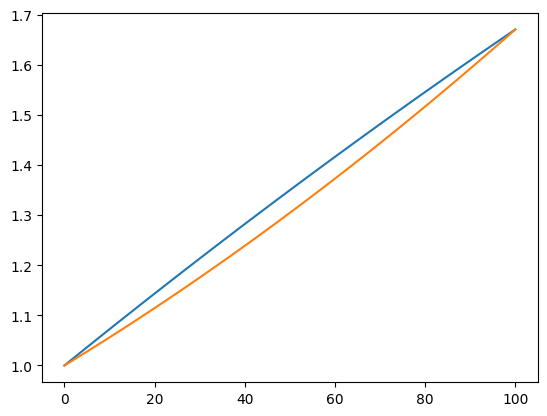

In [393]:
R = results_AWG['R_mean']
N = 100
P = np.concatenate([np.arange(N+1), np.arange(N-1, -1, -1)])
P_reset, P_set = get_f(P, R, N)

## AWG

In [222]:
n = 50
wf_dict_AWG = {
    'V' : [-2.6, -2.7, 2.3, 2.4], # pulse voltages
    'n' : [n, n, n, n],   # pulse repetitions
    'T' : 2e-3,     # pulse period
    'W' : 1e-4,     # pulse width
    'read' : True,
    'read_V' : .3,
    'ch' : 1
}
get_and_set_wf('AWG', wf_dict_AWG)

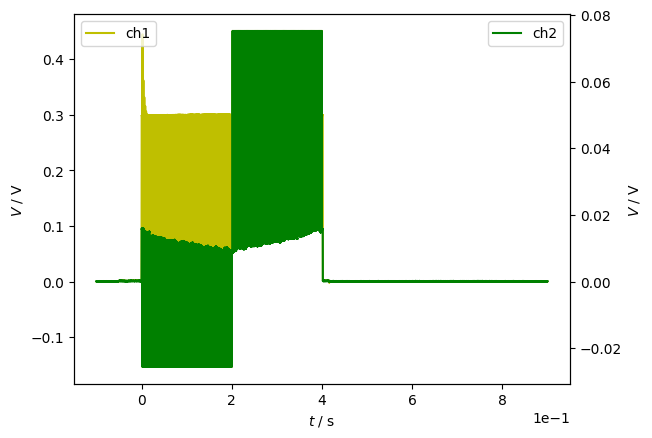

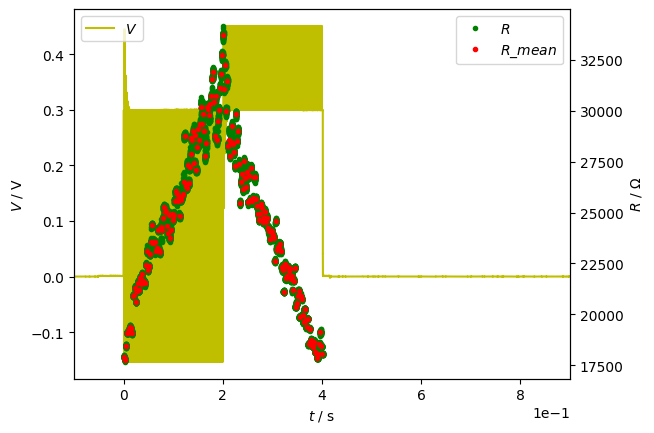

In [226]:
results_AWG = meas_AWG(113, wf_dict_AWG, [1, 2], R_s=1e3, R_min=5e3)

In [24]:
with open(f"meas_dict/AWG_{date.today()}.json", "r") as json_file:
    meas_dict_AWG = json.load(json_file)

## SMU

In [18]:
wf_dict_SMU = {
    'V' : [1, -1],
    'n' : [10, 10],
    'T' : 1e-2,
    'W' : 2e-3,
    'read' : True,
    'read_V' : .1,
    'ch' : 2
}
get_and_set_wf('SMU', wf_dict_SMU)

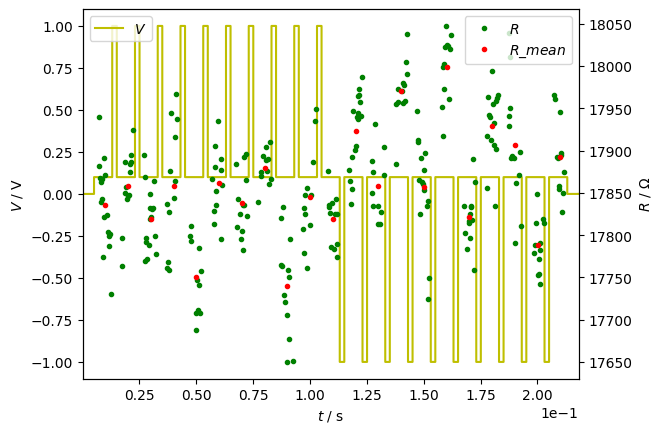

In [19]:
results_SMU = meas_SMU(111, wf_dict_SMU, [1, 2])

In [40]:
with open(f"meas_dict/SMU_{date.today()}.json", "r") as json_file:
    meas_dict_SMU = json.load(json_file)

## AWG_SMU

In [60]:
g = 10
T = 1e-3
W = 2e-4
wf_dict_AWG_list = [
    {
        'V' : [-2.6],
        'n' : [g],
        'T' : T,
        'W' : W,
        'read' : False,
        'read_V' : 0,
        'ch' : 1
    }, {
        'V' : [2.4],
        'n' : [g],
        'T' : T,
        'W' : W,
        'read' : False,
        'read_V' : 0,
        'ch' : 1
    }
]

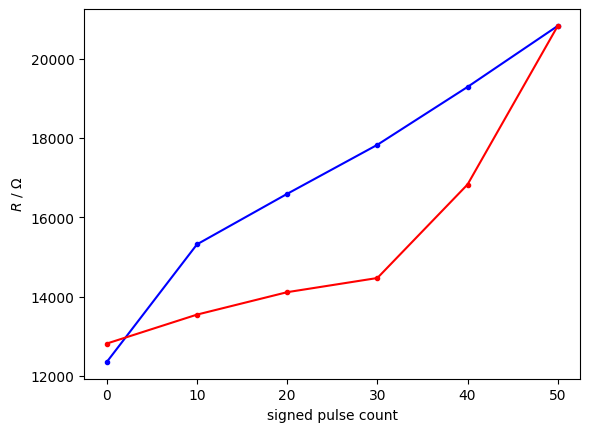

In [62]:
n = 5
N = [n, n]
results = meas_AWG_SMU(wf_dict_AWG_list, N, 113, 111, 0.5, R_s = 1e3)